In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import sys
if "/content/drive/My Drive/Machine Learning/lib/" not in sys.path:
    sys.path.append("/content/drive/My Drive/Machine Learning/lib/")

In [4]:
from gym.envs.toy_text import CliffWalkingEnv
import plotting

import gym
import math
import numpy as np
import random
import itertools
from collections import namedtuple, defaultdict

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import matplotlib.pyplot as plt
%matplotlib inline

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

## 测试环境

In [5]:
env = CliffWalkingEnv()

In [6]:
def get_screen(state):
    """这里我们就用state来作为例子, 不直接使用截图了, 将编号转换为one-hot向量, 共48维
    """
    y_state = torch.Tensor([[state]]).long()
    y_onehot = torch.FloatTensor(1, 48) # 产生位置
    # In your for loop
    y_onehot.zero_() # 全部使用0进行填充
    y_onehot.scatter_(1, y_state, 1) # 返回one-hot
    return y_onehot

In [7]:
get_screen(1)

tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

## 建立模型

In [24]:
class ActorCriticModel(nn.Module):
    def __init__(self):
        super(ActorCriticModel, self).__init__()
        self.fc1 = nn.Linear(48, 24)
        self.fc2 = nn.Linear(24, 12)
        self.action = nn.Linear(12, 4)
        self.value = nn.Linear(12, 1)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        action_probs = F.softmax(self.action(x), dim=-1)
        state_values = self.value(x)
        return action_probs, state_values

In [25]:
ac = ActorCriticModel()
action_probs, state_values = ac(get_screen(1).squeeze(0))
print(action_probs)
print(state_values)

tensor([0.2140, 0.3271, 0.2130, 0.2459], grad_fn=<SoftmaxBackward>)
tensor([-0.3331], grad_fn=<AddBackward0>)


In [26]:
ac = ActorCriticModel()
action_probs, state_values = ac(get_screen(1))
print(action_probs)
print(state_values)

tensor([[0.2368, 0.2305, 0.2719, 0.2608]], grad_fn=<SoftmaxBackward>)
tensor([[-0.3603]], grad_fn=<AddmmBackward>)


In [19]:
from torchsummary import summary

In [23]:
summary(ac, get_screen(1).size())

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 1, 24]           1,176
            Linear-2                [-1, 1, 12]             300
            Linear-3                 [-1, 1, 4]              52
            Linear-4                 [-1, 1, 1]              13
Total params: 1,541
Trainable params: 1,541
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.01
Estimated Total Size (MB): 0.01
----------------------------------------------------------------


## 开始训练

In [43]:
def trainIters(env, ActorCriticModel, num_episodes, gamma = 0.9):
    optimizer = torch.optim.Adam(ActorCriticModel.parameters(), 0.03) # 注意学习率的大小
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9)

    # 记录reward和总长度的变化
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes+1),
        episode_rewards=np.zeros(num_episodes+1))

    for i_episode in range(1, num_episodes+1):
        # 开始一轮游戏
        state = env.reset() # 环境重置
        state = get_screen(state) # 将state转换为one-hot的tensor, 用作网络的输入.

        log_probs = []
        rewards = []
        state_values = []

        for t in itertools.count():
            action_probs, state_value = ActorCriticModel(state.squeeze(0)) # 返回当前state下不同action的概率

            action = torch.multinomial(action_probs, 1).item() # 选取一个action
            log_prob = torch.log(action_probs[action])
            next_state, reward, done, _ = env.step(action) # 获得下一个状态

            # 计算统计数据
            stats.episode_rewards[i_episode] += reward # 计算累计奖励
            stats.episode_lengths[i_episode] = t # 查看每一轮的时间

            # 将值转换为tensor
            reward = torch.tensor([reward], device=device)
            next_state_tensor = get_screen(next_state)

            # 将信息存入List
            log_probs.append(log_prob.view(-1))
            rewards.append(reward)
            state_values.append(state_value)

            # 状态更新
            state = next_state_tensor

            if done: # 当一轮结束之后, 开始更新
                returns = []

                Gt = 0
                pw = 0

                # print(rewards)
                for reward in rewards[::-1]:
                    Gt = Gt + (gamma ** pw) * reward # 写成Gt += (gamma ** pw) * reward, 最后returns里东西都是一样的
                    # print(Gt)
                    pw += 1
                    returns.append(Gt)

                returns = returns[::-1]

                returns = torch.cat(returns)
                returns = (returns - returns.mean()) / (returns.std() + 1e-9)
                # print(returns)
                log_probs = torch.cat(log_probs)
                state_values = torch.cat(state_values)

                # print(returns)
                # print(log_probs)
                # print(state_values)

                advantage = returns.detach() - state_values

                critic_loss = F.smooth_l1_loss(state_values, returns.detach())
                actor_loss = (-log_probs * advantage.detach()).mean()
                loss = critic_loss + actor_loss

                # 更新critic
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                print('Episode: {}, total steps: {}'.format(i_episode, t))

                if t>20:
                    scheduler.step()

                break 
        
    return stats

In [44]:
ActorCritic = ActorCriticModel()
stats = trainIters(env, ActorCritic, 300)

Episode: 1, total steps: 55594
Episode: 2, total steps: 1822
Episode: 3, total steps: 49070
Episode: 4, total steps: 3906
Episode: 5, total steps: 12185
Episode: 6, total steps: 6338
Episode: 7, total steps: 23314
Episode: 8, total steps: 397
Episode: 9, total steps: 5815
Episode: 10, total steps: 648
Episode: 11, total steps: 547
Episode: 12, total steps: 652
Episode: 13, total steps: 126
Episode: 14, total steps: 106
Episode: 15, total steps: 76
Episode: 16, total steps: 59
Episode: 17, total steps: 55
Episode: 18, total steps: 317
Episode: 19, total steps: 46
Episode: 20, total steps: 27
Episode: 21, total steps: 144
Episode: 22, total steps: 35
Episode: 23, total steps: 74
Episode: 24, total steps: 103
Episode: 25, total steps: 106
Episode: 26, total steps: 76
Episode: 27, total steps: 57
Episode: 28, total steps: 28
Episode: 29, total steps: 35
Episode: 30, total steps: 27
Episode: 31, total steps: 18
Episode: 32, total steps: 42
Episode: 33, total steps: 28
Episode: 34, total ste

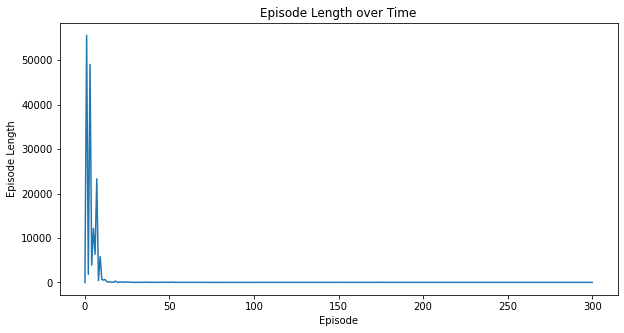

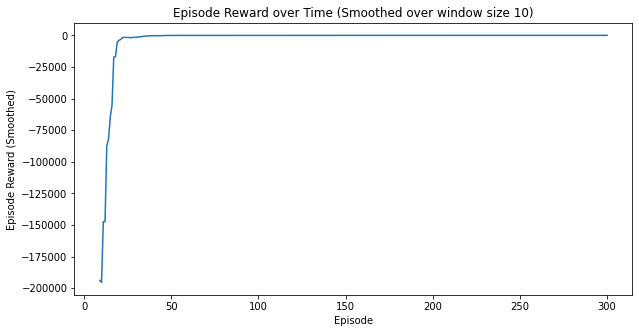

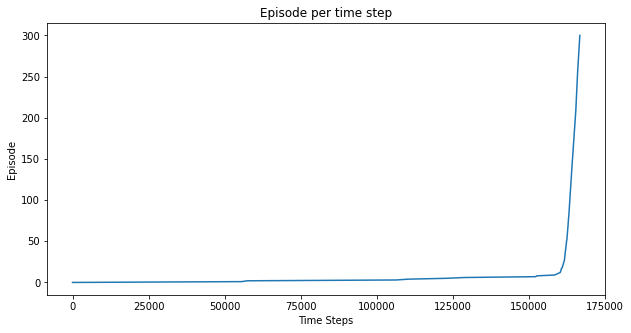

(<Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>)

In [45]:
plotting.plot_episode_stats(stats)